In [10]:
import torch
from torch import nn
import time
import matplotlib.pyplot as plt
import torch.nn.functional as F

from asdfghjkl import batch_gradient
from laplace.curvature.asdl import _get_batch_grad

import sys

sys.path.append("../stochman")

from stochman import nnj

sys.path.append("../../Laplace")
from laplace.laplace import Laplace
from torch.utils.data import DataLoader, TensorDataset


In [11]:
def get_model(number_of_layers, device, data_resolution, conv=False):

    if not conv:
        model = [nn.Linear(data_resolution, data_resolution)]
        for i in range(number_of_layers-1):
            model += [nn.Tanh(), nn.Linear(data_resolution, data_resolution)]
        model = nn.Sequential(*model).to(device)

    else:
        model = [nn.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        for i in range(number_of_layers-1):
            model += [nn.Tanh(), nn.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        model = nn.Sequential(*model).to(device)    

    return model

def get_model_stochman(number_of_layers, device, data_resolution, conv=False):

    if not conv:
        model = [nnj.Linear(data_resolution, data_resolution)]
        for i in range(number_of_layers-1):
            model += [nnj.Tanh(), nnj.Linear(data_resolution, data_resolution)]
        model = nn.Sequential(*model).to(device)
    
    else:
        model = [nnj.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        for i in range(number_of_layers-1):
            model += [nnj.Tanh(), nnj.Conv2d(data_resolution, data_resolution, kernel_size=(3,3), padding=(1,1), stride=1, bias=False)]
        model = nn.Sequential(*model).to(device)    
        
    return model

def get_model_stochman2(number_of_layers, input_shape, device, conv=False):

    if conv:
        model = [nnj.Conv2d(input_shape[0], 3, kernel_size=(3,3), padding=(1,1), stride=1, bias=False),
                nnj.Tanh(), 
                nnj.Upsample(scale_factor=2),
                nnj.Conv2d(3, 2, kernel_size=(3,3), padding=(0,0), stride=1, bias=False),
                nnj.Tanh(), 
                nnj.Conv2d(2, 3, kernel_size=(3,3), padding=(0,0), stride=1, bias=False)]
    else:
        model = [nnj.Linear(input_shape[0], 2*input_shape[0]),
                nnj.Tanh(), 
                nnj.Linear(2*input_shape[0], 4*input_shape[0]),
                nnj.Tanh(), 
                nnj.Linear(4*input_shape[0], 3*input_shape[0])]

    model = nn.Sequential(*model).to(device)    
        
    return model

In [12]:
def jacobians(x, model, output_size=784):
    jacobians = list()
    f = None
    for i in range(output_size):
        def loss_fn(outputs, targets):
            return outputs[:, i].sum()

        f = batch_gradient(model, loss_fn, x, None).detach()
        jacobian_i = _get_batch_grad(model)

        jacobians.append(jacobian_i)
    jacobians = torch.stack(jacobians, dim=1)
    return jacobians, f

def jacobians_conv(x, model, output_shape=(2,8,8)):
    jacobians = list()
    f = None
    for c in range(output_shape[0]):
        for h in range(output_shape[1]):
            for w in range(output_shape[2]):
                def loss_fn(outputs, targets):
                    return outputs[:, c, h, w].sum()

                f = batch_gradient(model, loss_fn, x, None).detach()
                jacobian_i = _get_batch_grad(model)

                jacobians.append(jacobian_i)
    jacobians = torch.stack(jacobians, dim=1)
    return jacobians, f
    
def run_row(x, output_shape, model, conv=False):

    t0 = time.perf_counter()
    if not conv:
        Js_row, _ = jacobians(x, model, output_size=output_shape[0])      
    else:
        Js_row, _ = jacobians_conv(x, model, output_shape=output_shape)        
    Hs_row = torch.einsum("nji,njk->nik", Js_row, Js_row)
    elapsed_row = time.perf_counter() - t0
    #print(Js_row.shape, Hs_row.shape)

    return Hs_row.detach().cpu(), elapsed_row


In [13]:
def run_laplace(x, data_resolution, model, conv=False, number_of_layers=0, device=None):

    nn_model = get_model(number_of_layers, device, data_resolution, conv=conv)
    for nn_layer, nnj_layer in zip(nn_model, model):
        if hasattr(nn_layer,'weight'):
            nn_layer.weight = nnj_layer.weight
        if hasattr(nn_layer,'bias'):
            nn_layer.bias = nnj_layer.bias

    t0 = time.perf_counter()
    dataset = TensorDataset(x, x)
    dataloader = DataLoader(dataset, batch_size=32)
    la = Laplace(
        nn_model,
        "regression",
        hessian_structure="diag",
        subset_of_weights="all",
    )
    la.fit(dataloader)
    elapsed_la = time.perf_counter() - t0

    return la.H.detach().cpu(), elapsed_la

In [14]:
def run_layer(x, output_shape, model, conv=False):
    t0 = time.perf_counter()

    bs = x.shape[0]
    H = []

    feature_maps = []

    def fw_hook_get_latent(module, input, output):
        feature_maps.append(output.detach())

    for k in range(len(model)):
        model[k].register_forward_hook(fw_hook_get_latent)

    model(x)
    feature_maps = [x] + feature_maps
    if conv:
        tmp = torch.diag_embed(torch.ones(output_shape[0]*output_shape[1]*output_shape[2], device=x.device)).expand(bs,-1,-1)
    else:
        tmp = torch.diag_embed(torch.ones(output_shape, device=x.device)).expand(bs,-1,-1)

    with torch.no_grad():
        for k in range(len(model) - 1, -1, -1):

            # jacobian w.r.t weight
            h_k = model[k]._jacobian_wrt_weight_sandwich(
                feature_maps[k],
                feature_maps[k + 1],
                tmp,
                diag=False,
            )
            if h_k is not None:
                H = [h_k.sum(dim=0)] + H
                print(f"hessian for layer {k} has shape {h_k.shape}")
            
            # jacobian w.r.t input
            tmp = model[k]._jacobian_wrt_input_sandwich(
                feature_maps[k],
                feature_maps[k + 1],
                tmp,
                diag=False,
            )
    #H = torch.cat(H, dim=0).detach().cpu()
    H = [H_layer.detach().cpu() for H_layer in H]

    elapsed_layer = time.perf_counter() - t0
    return H, elapsed_layer

# Compute and check results

In [15]:
def compute_hessians(number_of_layers=5, data_shape=(2,3,5,5), convolutions=True):
    batch_size, input_shape = data_shape[0], data_shape[1:]

    if convolutions:
        #channel, height, width = input_shape
        data = torch.randint(1,10,(batch_size,input_shape[0],input_shape[1],input_shape[2])).float()
    else:
        input_size = input_shape[0]
        data = torch.randint(1,10,(batch_size,input_size)).float()

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model = get_model_stochman2(number_of_layers, input_shape, device, conv=convolutions)

    output_shape = model(data).shape[1:]
    print(f"input shape: {data_shape[1:]}, output shape: {output_shape}, batch size: {data_shape[0]}")

    Hs_row, t_row = run_row(data, output_shape, model, conv=convolutions)
    Hs_row = Hs_row.sum(dim=0) #sum over batch size

    Hs_layer, t_layer = run_layer(data, output_shape, model, conv=convolutions)
    
    #if do_laplace:
    #    Hs_laplace, t_laplace = run_laplace(data, data_resolution, model, conv=convolutions,
    #                                        number_of_layers=number_of_layers, device=device)
    #else:
    #    Hs_laplace, t_laplace = None, None

    return Hs_row, t_row, Hs_layer, t_layer #, Hs_laplace, t_laplace



In [16]:
def check_correctness(number_of_layers=5, data_shape=(2,3,5,5), convolutions=True, plot=True):
    Hs_row, t_row, Hs_layer, t_layer = compute_hessians(number_of_layers = number_of_layers, 
                                                        data_shape = data_shape, 
                                                        convolutions = convolutions)

    assert number_of_layers == len(Hs_layer)
    print(f"Times \n -row method: {t_row}\n -layer method: {t_layer}")
    
    if convolutions:
        if number_of_layers==1:
            print('Error max abs value:', torch.max(torch.abs(Hs_row - Hs_layer[0])) )
            if plot:
                plt.figure()
                plt.imshow(Hs_row.numpy())
                plt.title('Row by row method')
                plt.figure()
                plt.imshow(Hs_layer[0].numpy())
                plt.title('Layer by layer method')
        else:
            tot_w = 0
            Hs_row_block_diagonal = []
            for l in range(number_of_layers):
                block_Hs_layer = Hs_layer[l] 
                this_w = block_Hs_layer.shape[0]
                block_Hs_row = Hs_row[tot_w:tot_w+this_w, tot_w:tot_w+this_w] 
                tot_w += this_w
                print('Error max abs value on layer',l,':', torch.max(torch.abs(block_Hs_row - block_Hs_layer)) )
                Hs_row_block_diagonal.append(block_Hs_row)
            if plot:
                plt.figure()
                plt.imshow(Hs_row.numpy())
                plt.title('Row by row method (full)')
                plt.figure()
                for l in range(number_of_layers):
                    plt.subplot(1,number_of_layers,l+1)
                    plt.title('layer'+str(l))
                    plt.imshow(Hs_row_block_diagonal[l].numpy())
                plt.suptitle('Row by row method (diagonal blocks)')
                plt.figure()
                for l in range(number_of_layers):
                    plt.subplot(1,number_of_layers,l+1)
                    plt.title('layer'+str(l))
                    plt.imshow(Hs_layer[l].numpy())
                plt.suptitle('Layer by layer method (diagonal blocks)')
        
    else:
        Hs_layer = torch.cat(Hs_layer, dim=0)
        print('Error max abs value (ours):', torch.max(torch.abs( Hs_layer - torch.diagonal(Hs_row) )) )

In [17]:
check_correctness(number_of_layers = 3, 
                  data_shape=(2,10), 
                  convolutions = False, 
                  plot = True)

input shape: (10,), output shape: torch.Size([30]), batch size: 2
hessian for layer 4 has shape torch.Size([2, 1230])
hessian for layer 2 has shape torch.Size([2, 840])
hessian for layer 0 has shape torch.Size([2, 220])
Times 
 -row method: 0.05630107401520945
 -layer method: 0.0024929940118454397
Error max abs value (ours): tensor(2.3842e-06)


input shape: (3, 5, 5), output shape: torch.Size([3, 6, 6]), batch size: 2
hessian for layer 5 has shape torch.Size([2, 54, 54])
hessian for layer 3 has shape torch.Size([2, 54, 54])
transpoooo
hessian for layer 0 has shape torch.Size([2, 81, 81])
Times 
 -row method: 0.21660370100289583
 -layer method: 0.013940063014160842
Error max abs value on layer 0 : tensor(1.5259e-05)
Error max abs value on layer 1 : tensor(9.5367e-06)
Error max abs value on layer 2 : tensor(9.5367e-07)


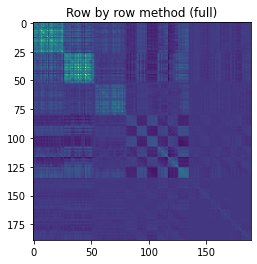

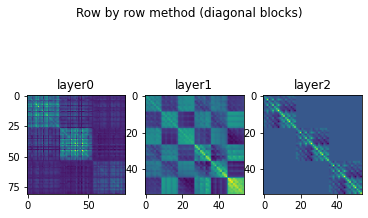

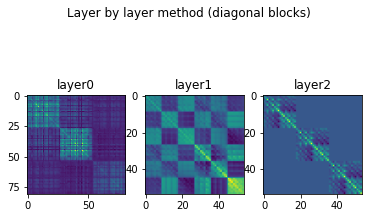

In [18]:
check_correctness(number_of_layers = 3, 
                  data_shape=(2,3,5,5), 
                  convolutions = True, 
                  plot = True)